In [618]:
!pip install pandas
!pip install -U matplotlib\
install tqdm

In [619]:
from datetime import timedelta
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
#%tensorflow_version 1.x

# Data

In [621]:
## Currently using data from https://doi.org/10.4121/uuid:5b82f3c9-c48a-4e01-983d-e1e20e39027c having temperature sensor data
## Each day has 480 readings, each reading carried every 3 mins.
df = pd.read_csv("/Users/Erik Mitchell/Research Project/datasets/cleaned_data.csv")
df.head(10)

,temperature,time_interval,price_energy
0,29.941,0,1
1,29.941,1,1
2,29.941,2,1
3,29.966,3,1
4,29.941,4,1
5,29.916,5,1
6,29.890,6,1
7,29.916,7,1
8,29.941,8,1
9,29.941,9,1


# Home Sim Environment

In [622]:
class Home():
    """A simple Home Energy Model.
    Parameters:
        * heat_mass_capacity:           capacity of the building's heat mass [J/K]
        * heat_transmission:            heat transmission to the outside [W/K]
        * maximum_cooling_power:        [W] (<= 0)
        * maximum_heating_power:        [W] (>= 0)
        * time_step_size:               [s]
        * conditioned_floor_area:       [m**2]
    """

    def __init__(self, heat_mass_capacity, heat_transmission,
                 maximum_cooling_power, maximum_heating_power, time_step_size, 
                 conditioned_floor_area, heating_setpoint, cooling_setpoint, outside_data):

        if maximum_heating_power < 0:
            raise ValueError("Maximum heating power [W] must not be negative.")
        if maximum_cooling_power > 0:
            raise ValueError("Maximum cooling power [W] must not be positive.")

        # CONSTANT VALUES
        self.__heat_mass_capacity = heat_mass_capacity
        self.__heat_transmission = heat_transmission
        self.__maximum_cooling_power = maximum_cooling_power
        self.__maximum_heating_power = maximum_heating_power
        self.__time_step_size = time_step_size
        self.__conditioned_floor_area = conditioned_floor_area
        self.heating_setpoint = heating_setpoint
        self.cooling_setpoint = cooling_setpoint

        # VARYING VALUES
        self.outside_data = outside_data
        self.current_heating_cooling_power = None
        self.current_int_temperature = None
        self.current_ext_temperature = None
        self.current_time_interval = None
        self.current_energy_price = None

        def create_actionspace():
            """
            From the heating and cooling setpoints creating actions space with interval of 500 units between them.
            """
            
            i = 0
            j = self.__maximum_cooling_power
            
            action_space = {}
            
            while j <= self.__maximum_heating_power:
                action_space[i] = j
                i += 1
                j += 500

            return action_space
        
        self.action_space = create_actionspace()

    def value_to_action(self, value):
        """
        Used to convert required heating_cooling_power (predicted using FORMULA method not Agent)  
        into a specific action.
        """
        
        for i, j in building.action_space.items():
            if abs(j - value) < 500:
                if value < 0:
                    return(i+1)
                else:
                    return(i)

    def next_ext_data(self):
        """
        Data generator for agent providing external temperature and time.
        """
        while True:
            for i in range(len(self.outside_data)):    
                temp, time, price = self.outside_data.iloc[i, :]
                yield temp, time, price

    def initialize_state(self, initial_int_temp):
        """
        Used the reset environment.
        """
        self.current_int_temperature = initial_int_temp
        self.current_heating_cooling_power = None
        self.current_energy_price = None
        self.ext_data_generator = self.next_ext_data()
        self.update_ext_data()

        return self.current_state()
    

    def update_ext_data(self):
        """
            External Temperature and Time Interval getting updated by the data generator
        """
        self.current_ext_temperature, self.current_time_interval, self.current_energy_price = self.ext_data_generator.__next__()



    def _next_temperature(self, heating_cooling_power):
        """
        Based on the current status of building and input heating cooling power, predict the
        next temperature.
        """
        dt_by_cm = self.__time_step_size.total_seconds() / self.__heat_mass_capacity

        return (self.current_int_temperature * (1 - dt_by_cm * self.__heat_transmission) +
        dt_by_cm * (heating_cooling_power + self.__heat_transmission * self.current_ext_temperature))

# state : time_interval, current_int_temperature, current_ext_temperature
# state will be input to agent and agent will give amount of heating_cooling_power that will be needed to be applied
# heating_cooling_power will the action that will be taken

    def step(self, action):
        """
        Predicts by MODEL built in agent.
            Input : heating cooling power
            Output :  Should return the Next temperature, Reward 
        """
        self.current_heating_cooling_power = self.action_space[action]

        # calculate new Temperature
        next_temperature = self._next_temperature(self.current_heating_cooling_power)

        # scaling reward factor for temperature range penalty
        L = 10
        # Cost of provding heating or cooling
        operation_cost = abs(self.current_heating_cooling_power) / 100
        
        #scaling reward factor for peak penalty
        M = 5
        # Cost of providing heating or cooling during peak times
        pricing_cost = abs(self.current_energy_price * M)

        # Cost of temperature going outside the desired range of set points
        out_of_bounds_cost = abs(next_temperature - self.cooling_setpoint) + abs(next_temperature - self.heating_setpoint)

        # As going out of bounds is more costly for us
        # total_cost = operation_cost - L * out_of_bounds_cost
        if self.cooling_setpoint <= next_temperature <= self.heating_setpoint :
            total_cost = 100 - operation_cost - pricing_cost
        else:
            total_cost = -L * out_of_bounds_cost - operation_cost - pricing_cost

        # Updating to new state
        self.current_int_temperature = next_temperature
        self.update_ext_data()

        return self.current_state(), total_cost, pricing_cost, operation_cost, next_temperature
    

    def predicting_step(self):
        """
        Predicts by FORMULA the appropriate heating/cooling power to maintain the temperature 
        within setpoints
        """

        def next_temperature(heating_cooling_power):
            return self._next_temperature(heating_cooling_power = heating_cooling_power)

        next_temperature_no_power = next_temperature(0)

        # if temperature is within limits by the system being off, do nothing return power as 0
        if (next_temperature_no_power >= self.heating_setpoint and
            next_temperature_no_power <= self.cooling_setpoint):
            return 0
        # Else, devise a way to determine the required heating/cooling required
        else:
            if next_temperature_no_power < self.heating_setpoint:
                setpoint = self.heating_setpoint
                max_power = self.__maximum_heating_power

            else:
                setpoint = self.cooling_setpoint
                max_power = self.__maximum_cooling_power

            ten_watt_per_square_meter_power = 10 * self.__conditioned_floor_area
            next_temperature_power_10 = next_temperature(ten_watt_per_square_meter_power)

            unrestricted_power = (ten_watt_per_square_meter_power *
                                  (setpoint - next_temperature_no_power) /
                                  (next_temperature_power_10 - next_temperature_no_power))

            if abs(unrestricted_power) <= abs(max_power):
                return self.value_to_action(unrestricted_power)
            else:
                return self.value_to_action(max_power)


    def current_state(self):
        """
        Returns the current state of the building environment.
        """
        return [self.current_time_interval, self.current_int_temperature, self.current_ext_temperature, self.current_energy_price]

In [623]:
# Creating Building environment which the agent will interact with

conditioned_floor_area = 200
building = Building(
    heat_mass_capacity=165000 * conditioned_floor_area,
    heat_transmission=500,
    conditioned_floor_area=conditioned_floor_area,
    maximum_cooling_power=-10000,
    maximum_heating_power=10000,
    time_step_size=timedelta(minutes=3),
    heating_setpoint=24, 
    cooling_setpoint=19,
    outside_data = df
)

In [624]:
# Discount reward over time. Negative and positive rewards are handled seperately.

def discounted_reward(reward, i):
    FACTOR = 0.999
    if reward <= 0:
        return reward / np.power(FACTOR, i)
    else:
        return reward * np.power(FACTOR, i)

In [625]:
#initializing the state attributes, loading data and returning the first state
# the initial internal temperature of the biulding is passed as input
# equivalent to env.reset() from gym

initial_state = building.initialize_state(30)

# Constants

n_actions = len(building.action_space)
input_shape = np.shape(initial_state)
intervals_per_day = 480

# Model Definition

In [626]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()

c:\users\erik mitchell\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [627]:
from keras.layers import Dense, InputLayer
from keras.models import Sequential

class Agent:
    
    def __init__(self, name, n_actions, input_shape,  epsilon, reuse = False):
        with tf.compat.v1.variable_scope(name, reuse):
            
            """
            Model Defination
            """
            
            self.network = Sequential()
            self.network.add(Dense(100, activation="relu", input_shape=input_shape ))
            self.network.add(Dense(100, activation="relu"))
            self.network.add(Dense(n_actions, activation="linear"))
            
            self.state_t = tf.compat.v1.placeholder("float32", [None, ] + list(input_shape))
            self.qvalues = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon
        
    def get_qvalues(self, state_t):
        """
            Will be called in the function by the agent which will pass the state
            in the form of an array.
            Runs the graph that computes the qvalues
        """
        sess = tf.compat.v1.get_default_session()
        return sess.run(self.qvalues, {self.state_t : state_t})

    def get_symbolic_qvalues(self, state_t):
        """
        After get_qvalues function is called we get the 
        """

        qvalues = self.network(state_t)

        return qvalues

    def sample_actions(self, qvalues):
        """
            Sampling actions from the batch of qvalues
        """
        batch_size, n_actions = qvalues.shape

        #get random and best actions for each qvalue in batch
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        # choose whether to explore or exploit based on epsilon. Choice is made for each 
        #element in batch
        should_explore = np.random.choice([0,1], batch_size, p = [1-self.epsilon, self.epsilon])

        # Return Actions according to choice made in should explore

        return np.where(should_explore, random_actions, best_actions)

# Initialization of Agent and Target Networks

In [628]:
agent = Agent("Agent", n_actions, input_shape, epsilon=0.5)
sess.run(tf.compat.v1.global_variables_initializer())

In [629]:
target_network = Agent("target_network", n_actions, input_shape, epsilon=0)

In [630]:
# Initializes/resets building

building.initialize_state(22)

[0.0, 22, 29.941, 1.0]

In [631]:
def restart_model(building, n_actions, input_shape, epsilon):
    """
    Called when we require to reset the agent with edits and restart the training from scratch
    """
    agent = Agent("Agent", n_actions, input_shape, epsilon=0.5)
    target_network = Agent("target_network", n_actions, input_shape, epsilon=0)
    building.initialize_state(22)
    sess.run(tf.compat.v1.global_variables_initializer())
    
    return agent, target_network

# Evaluating Model Performance (Training)

In [632]:
# Evaluate function which will run our agent to work 
# Greedy mode will be run when we want to deploy the model and no longer run the model

def evaluate(agent, building, n_days, intervals_per_day, greedy = False):
    """
    Evaluates how well the model performs over a period of days.
    Returns the overall rewards
    """
    
    rewards = []
    p_costs = []
    o_costs = []
    temps = []
    for _ in range(n_days):
        reward = 0
        p_cost = 0
        o_cost = 0
        s = building.current_state()
        for i in range(intervals_per_day):
            temp = 0
            
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, p, o, t = building.step(action)
            #print(discounted_reward(r, i))
            reward += discounted_reward(r, i)
            p_cost += p
            o_cost += o
            temp += t
        
        rewards.append(reward)
        
        p_costs.append(p)
        o_costs.append(o)
        temps.append(t)
        
    return np.mean(rewards), np.mean(p_costs), np.mean(o_costs), temps

# Running agent

In [633]:
def play_and_record(agent, building, replay_buffer, n_iterations):
    """
    Run the agent to predict at "n_iterations" amount of time_intervals.
    Every step, the state, action, reward, next_state will be recorded in the replay_buffer
    Record rewards over the time_intervals
    """
    
    s = building.current_state()
    
    reward = 0.0
    
    for t in range(n_iterations):
        
        qvalues = agent.get_qvalues([s])         # [s] cause we will pass s later in a batch
        a = agent.sample_actions(qvalues)[0]
        next_s, r, z, y, w = building.step(a)
        
        # Adding to replay buffer
        
        replay_buffer.add(state = s, action = a, reward = r, next_state = next_s)
        reward += r
        
    return reward

# Transfering Agent weights to Target weights

In [634]:
def transfer_weights_to_target(agent, target_network):
    """
        During model designing we have defined self.weights that get weights of the network with name.
        We train the agent network. Then after few iterations we copy the weights from agent to target network

    """
    
    assigns = []
    
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        # Transfer weights layer by layer (i think so)
        assigns.append(tf.compat.v1.assign(w_target, w_agent, validate_shape=True))
        
    # Do the abobe transfers per layer
    tf.compat.v1.get_default_session().run(assigns)

# Loss Calculation

In [635]:
# Creating placeholders for <s,a,r,s'> which will be fed by the replay buffer
# (None, )  is added cause we will add many observations of batchsize to train the network at once

states = tf.compat.v1.placeholder(tf.float32, shape = (None, ) + input_shape)
actions = tf.compat.v1.placeholder(tf.int32, shape = [None])
rewards = tf.compat.v1.placeholder(tf.float32, shape = [None])
next_states = tf.compat.v1.placeholder(tf.float32, shape = (None, ) + input_shape)

# gamma (how much to focus on future reward in calculating target Q(s,a))

gamma = 0.9

# Predicted Q(s,a)

In [636]:
"""
get qvalues Q(s) from state. Since we're already dealing with tensors we dont call agent.get_qvalues 
which was used earlier.

We get Q(s,a) by multiplying a one hot vector of actions with the current_qvalues. This is the first
component of the loss function which is computed by the agent network. This is the approximated/predicted Q(s,a)
"""
current_qvalues = agent.get_symbolic_qvalues(states)

current_action_qvalues = tf.reduce_sum(tf.one_hot(actions, n_actions) * current_qvalues, axis=1)

# Target Q(s,a)

In [637]:
"""
The second part is the target Q(s,a) value which we get by reward. We calculate Q(next_state) by using the
target network which has older weights than target
"""

next_qvalues = target_network.get_symbolic_qvalues(next_states)

next_state_value = tf.reduce_max(next_qvalues, axis=-1)

# reference/target qvalue
# We divide rewards by a factor p, also clip values to max -1
#p = 100

target_action_qvalues = rewards + gamma * next_state_value

# Loss

In [638]:
# calculating loss

td_loss = tf.reduce_mean((current_action_qvalues - target_action_qvalues)**2)

# Learning rate at 0.001. We use adam optimizer and train on weights on agent

train_step = tf.compat.v1.train.AdamOptimizer(1e-3).minimize(td_loss, var_list=agent.weights)

In [639]:
sess.run(tf.compat.v1.global_variables_initializer())

In [640]:
# function to assign values to the placeholders computing loss from the experience replay buffer

def sample_batch(exp_replay, batch_size):
    sample = exp_replay.sample(batch_size)
    states_batch, action_batch, reward_batch, next_states_batch = sample["state"],sample["action"], sample["reward"],sample["next_state"]
    
    # temporary fix of shape which required (10, ) but got (10,1)
    action_batch = action_batch.ravel()
    reward_batch = reward_batch.ravel()
    
    return {
        states : states_batch,
        actions : action_batch,
        rewards : reward_batch,
        next_states : next_states_batch
    }

# Running Model

In [641]:
from tqdm import trange
from IPython.display import clear_output
import pandas as pd 
%matplotlib inline

In [642]:
agent, target_network = restart_model(building, n_actions, input_shape, 0.5)

## Experience Replay Buffer

In [643]:
!pip install cpprb

In [644]:
from cpprb import ReplayBuffer


mean_rw_history = []
td_loss_history = []
pricing_cost_history = []
operation_cost_history = []
temp_history = []

result_list = [mean_rw_history, pricing_cost_history, operation_cost_history, temp_history]



buffer_size = 20000
state_shape = 4
act_dim = 1
reward_dim = 1


exp_replay = ReplayBuffer(20000, env_dict = {"state": {"shape": state_shape}, "action": {"shape": act_dim}, 
                                           "reward": {"shape": reward_dim}, "next_state": {"shape": state_shape} })
play_and_record(agent, building, exp_replay, 100000)

-24226057.936614335

# Main Loop

iteration 800 and epsilon 0.4172568807250437


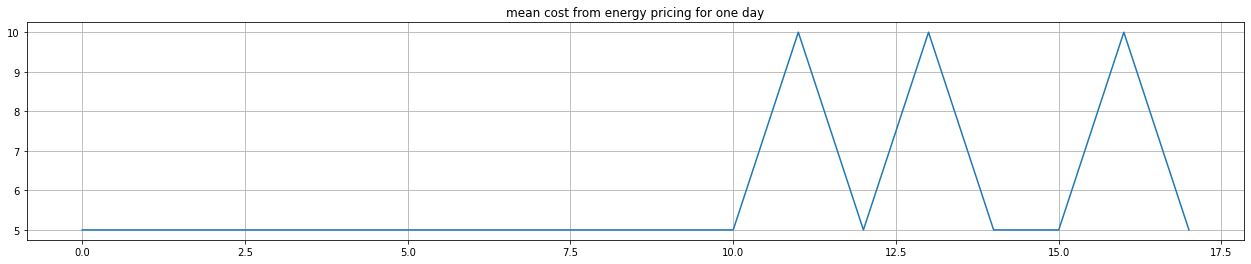

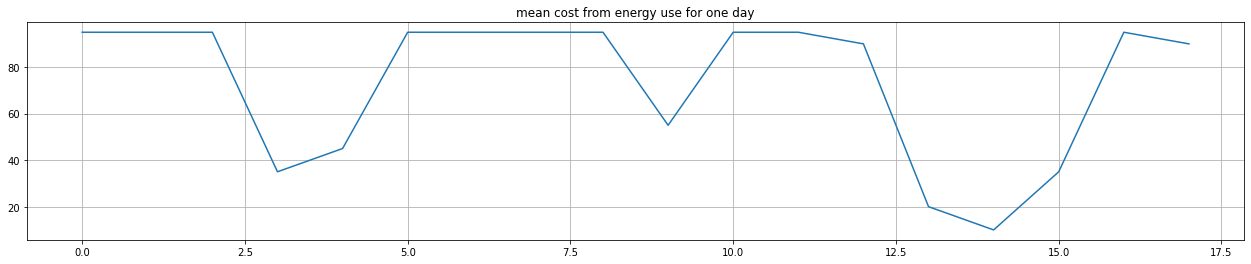

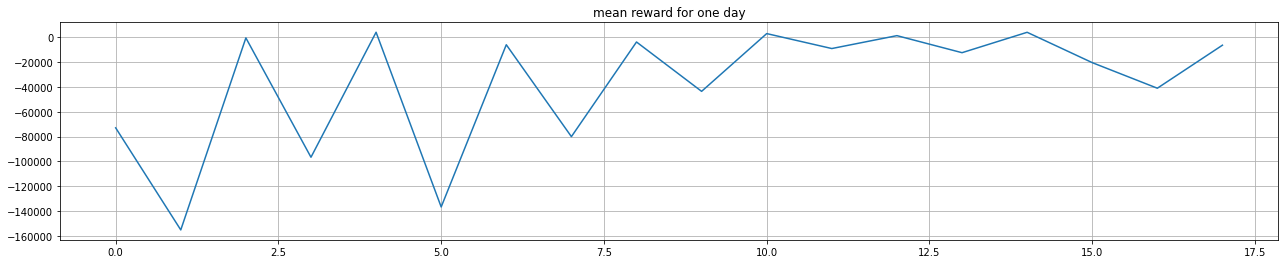

KeyboardInterrupt: 

In [646]:
for i in range(100000):
    
    # Run the agent
    
    play_and_record(agent, building, exp_replay, 100)
    
    # train the network with batch size 64
    
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, 64))
    td_loss_history.append(loss_t)
    
    # We adjust epsilon of agent and transfer weights from agent to target_network
    # Also evaluate agents performance in one day
    if i % 500 == 0:
        
        transfer_weights_to_target(agent, target_network)
        
        agent.epsilon = max(0.01, agent.epsilon * 0.99)
        
        for x, lst in zip((evaluate(agent=agent, building=building, n_days=1, intervals_per_day=intervals_per_day)), result_list):
            lst.append(x)
            
        #mr, mpc, moc = evaluate(agent=agent, building=building, n_days=1, intervals_per_day=intervals_per_day)
        #mean_rw_history.append(mr)
        #pricing_cost_history.append(mpc)
        #operation_cost_history.append(moc)
        #mean_rw_history.append(evaluate(agent=agent, building=building, n_days=1, intervals_per_day=intervals_per_day))
    if i == 200:
        td_loss_history = []
        
    if i % 100 == 0:
        clear_output(True)
        print(f'iteration {i} and epsilon {agent.epsilon}')
        
        plt.figure(figsize=[48, 4])
        plt.subplot(1,2,1)
        plt.title("mean cost from energy pricing for one day")
        plt.plot(pricing_cost_history)
        plt.grid()
        
        plt.figure(figsize=[48, 4])
        plt.subplot(1,2,1)
        plt.title("mean cost from energy use for one day")
        plt.plot(operation_cost_history)
        plt.grid()
        
        plt.figure(figsize=[48, 4])
        plt.subplot(1,2,1)
        plt.title("mean reward for one day")
        plt.plot(mean_rw_history)
        plt.grid()
        
        plt.figure(figsize=[48, 4])
        plt.subplot(1,2,1)
        plt.title("temp for each day")
        plt.plot(temp_history)
        plt.grid()
        
        plt.figure(figsize=[50, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss")
        plt.plot(td_loss_history)
        plt.grid()
        
        plt.show()

In [ ]:
def evaluate_by_model(agent, building, n_days, intervals_per_day, greedy = False):
    
    rewards = []
    for _ in range(n_days):
        reward = 0
        s = building.current_state()
        for i in range(intervals_per_day):
            
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0]
            s, r, u, k = building.step(action)
            reward += discounted_reward(r, i)
        
        rewards.append(reward)
        
    return rewards

In [ ]:
building.initialize_state(22)
rewards_model = evaluate_by_model(agent=agent, building=building, n_days=200, intervals_per_day=intervals_per_day)

In [ ]:
plt.plot(range(200), rewards_model, label = "model")
plt.show()